<a href="https://colab.research.google.com/github/AurelienCD/Formation_OCR_Ing_Machine_Learning/blob/main/P3_02_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connexion au google drive, déplacement dans le dossier contenant les données nécessaires au projet

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Formation_OCR_Ing_Machine_Learning/Projet 3

/content/drive/MyDrive/Formation_OCR_Ing_Machine_Learning/Projet 3


Importation des librairies nécessaires au projet

In [ ]:
import pandas as pad 
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import ttest_ind


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet, BayesianRidge, TweedieRegressor, HuberRegressor, QuantileRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pad.read_csv('data_projet3_clean.csv', sep='\t')

Exploration rapide des données

In [ ]:
df.shape

(1532, 25)

In [ ]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(therms),TotalGHGEmissions,GHGEmissionsIntensity,YearBuilt_age
0,1.0,2015.0,NonResidential,Hotel,7.0,DOWNTOWN,1927.0,1.0,12.0,88434.0,...,65.0,78.9,173.5,6981428.0,2023032.0,1080307.0,12724.0,249.43,2.64,old
1,2.0,2015.0,NonResidential,Hotel,7.0,DOWNTOWN,1996.0,1.0,11.0,103566.0,...,51.0,94.4,191.3,8354235.0,0.0,1144563.0,44490.0,263.51,2.38,old
2,10.0,2015.0,NonResidential,Hotel,7.0,DOWNTOWN,1926.0,1.0,11.0,83008.0,...,25.0,76.9,149.5,6252842.0,0.0,785342.0,35733.0,208.46,2.37,old
3,12.0,2015.0,NonResidential,Hotel,7.0,DOWNTOWN,1904.0,1.0,15.0,163984.0,...,46.0,77.0,174.6,12633744.0,0.0,2155728.0,52784.0,331.61,1.83,old
4,17.0,2015.0,NonResidential,Hotel,7.0,DOWNTOWN,1928.0,1.0,9.0,65009.0,...,39.0,104.7,166.5,6807227.0,1987163.0,473326.0,32051.0,334.87,5.04,old


In [ ]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'NaturalGas(therms)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'YearBuilt_age'],
      dtype='object')

# Création des variables d'intérêt :

Dans notre problématique de prédiction des émissions de GES et de consommation, pour moi il y aurait comme variables intéressantes en plus de celles de la databse :
  - Isolation des batiments
  - Nombre de fenêtre
  - Type d'énergie consommée

Nous n'avons pas les deux premières et aucun moyen par feature engineering de les retrouver à partir des données présentes
Pour la dernière on pourrait créer un feature avec le type d'énergie utilisé, on suppose facilement que si le batiment utilise "Steam", "Electricity" ou "NaturalGAS" sont bilan carbon ne sera pas le même, cependant dans l'AAP il est bien stipulé que le but à long terme est de se passer des relevés de consommation trop couteux, on ne peut donc pas se servir de cette variable

En revanche on peut créer ces features là :
  - « GFA_per_floor » (en plus de la surface totale et du nombre d'étage, la surface par étage pourrait être une information intéressante pour notre modèle
  - « Building_age » (exprime l'âge du batiment directement, ce sera sûrement plus parlant que la date de construction qui ne varie que de 5% (1900 vs 2000)

In [ ]:
df['GFA_per_floor'] = df['PropertyGFATotal'] / df['NumberofFloors']
df['Building_age'] = 2022 - df['YearBuilt']

In [ ]:
df.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(therms),TotalGHGEmissions,GHGEmissionsIntensity,GFA_per_floor,Building_age
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.0,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,...,1532.000000,1532.000000,1.532000e+03,1.532000e+03,1.532000e+03,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,15189.592037,2015.490209,4.344648,1958.757180,1.0,3.355744,74082.328982,6774.404047,67307.924935,62530.179504,...,51.555809,129.475261,3.612240e+06,9.941527e+04,7.823197e+05,8345.889858,70.607134,0.966397,29293.260956,63.242820
std,12450.877949,0.500067,2.194945,32.541263,0.0,2.758174,66720.168681,17959.627448,59857.023820,54490.822868,...,31.033147,80.447218,4.067234e+06,5.768289e+05,1.009597e+06,13863.269932,93.478450,1.022007,31827.396892,32.541263
min,1.000000,2015.000000,1.000000,1900.000000,1.0,1.000000,16300.000000,0.000000,16200.000000,8061.000000,...,1.800000,0.000000,4.394300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,3294.545455,7.000000
25%,611.000000,2015.000000,2.000000,1928.000000,1.0,1.000000,28846.250000,0.000000,28008.500000,25981.750000,...,29.900000,68.475000,1.069189e+06,0.000000e+00,1.821662e+05,0.000000,15.492500,0.220000,12113.125000,37.750000
50%,20871.000000,2015.000000,4.000000,1963.000000,1.0,3.000000,48112.000000,0.000000,45864.000000,41732.500000,...,47.099999,118.950001,2.067009e+06,0.000000e+00,3.939894e+05,3240.865112,37.420000,0.610000,20648.833333,59.000000
75%,24218.000000,2016.000000,7.000000,1984.250000,1.0,4.000000,94002.000000,0.000000,83008.000000,79384.000000,...,66.425000,171.125005,4.712360e+06,0.000000e+00,9.600228e+05,9936.879883,82.295000,1.350000,33514.000000,94.000000
max,50081.000000,2016.000000,7.000000,2015.000000,1.0,17.000000,411584.000000,101342.000000,411584.000000,388934.000000,...,216.000000,540.500000,2.843306e+07,1.092107e+07,8.306096e+06,122680.000000,940.470000,5.540000,411584.000000,122.000000


# Préparation du jeu de données pour l'entrainement des modèles :

La problématique est de prédire la consommation en énergie (variable *SiteEnergyUse(kBtu)*) et les émissions de GES (variable *TotalGHGEmissions*) sans avoir accès aux relevés qui sont couteux à obtenir (variables : *SiteEUI(kBtu/sf)* , *SourceEUI(kBtu/sf)*, *SteamUse(kBtu)*, *Electricity(kWh)*, *NaturalGas(therms)*)

Il faut donc exclures ces dernières variables pour l'entrainement des modèles

In [ ]:
data = df.drop(['SiteEUI(kBtu/sf)'], axis=1)
data = data.drop(['SourceEUI(kBtu/sf)'], axis=1)
data = data.drop(['SteamUse(kBtu)'], axis=1)
data = data.drop(['Electricity(kWh)'], axis=1)
data = data.drop(['NaturalGas(therms)'], axis=1)

La variable *GHGEmissionsIntensity* est intéressante mais ne dois pas être utilisée pour les modélisations, il faut donc la supprimer du dataset utilisé pour faire le modèle en la gardant dans une autre dataframe

In [ ]:
df_GES_Intensity = data["GHGEmissionsIntensity"]
data = data.drop(['GHGEmissionsIntensity'], axis=1)

C'est aussi vrai pour la variable *ENERGYSTARScore*, elle est intéressante mais ne dois pas être utilisée pour les modélisations, il faut donc la supprimer du dataset utilisé pour faire le modèle en la gardant dans une autre dataframe

In [ ]:
df_EnergyStarScore = data["ENERGYSTARScore"]
data = data.drop(['ENERGYSTARScore'], axis=1)

Suppression des dernières variables non utilisables pour le modèle

In [ ]:
data = data.drop(['DataYear'], axis=1)
data = data.drop(['YearBuilt'], axis=1)
data = data.drop(['NumberofBuildings'], axis=1)
data = data.drop(['OSEBuildingID'], axis=1)
data = data.drop(['BuildingType'], axis=1)
data = data.drop(['ListOfAllPropertyUseTypes'], axis=1)

Préparation des données utilisées pour les modèles de machine learning

In [ ]:
to_predict_features = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
Y = data[to_predict_features]
X = data.drop(to_predict_features, axis=1)

Split des features quantitatives et qualitatives :

In [ ]:
features_Quant = ['CouncilDistrictCode', 'NumberofFloors','PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'GFA_per_floor','Building_age',]
features_Qual = ['PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'YearBuilt_age']

In [ ]:
X.describe()

,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,GFA_per_floor,Building_age
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,4.344648,3.355744,74082.328982,6774.404047,67307.924935,62530.179504,29293.260956,63.242820
std,2.194945,2.758174,66720.168681,17959.627448,59857.023820,54490.822868,31827.396892,32.541263
min,1.000000,1.000000,16300.000000,0.000000,16200.000000,8061.000000,3294.545455,7.000000
25%,2.000000,1.000000,28846.250000,0.000000,28008.500000,25981.750000,12113.125000,37.750000
50%,4.000000,3.000000,48112.000000,0.000000,45864.000000,41732.500000,20648.833333,59.000000
75%,7.000000,4.000000,94002.000000,0.000000,83008.000000,79384.000000,33514.000000,94.000000
max,7.000000,17.000000,411584.000000,101342.000000,411584.000000,388934.000000,411584.000000,122.000000


In [ ]:
X.head()

,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,YearBuilt_age,GFA_per_floor,Building_age
0,Hotel,7.0,DOWNTOWN,12.0,88434.0,0.0,88434.0,Hotel,88434.0,old,7369.500000,95.0
1,Hotel,7.0,DOWNTOWN,11.0,103566.0,15064.0,88502.0,Hotel,83880.0,old,9415.090909,26.0
2,Hotel,7.0,DOWNTOWN,11.0,83008.0,0.0,83008.0,Hotel,81352.0,old,7546.181818,96.0
3,Hotel,7.0,DOWNTOWN,15.0,163984.0,0.0,163984.0,Hotel,163984.0,old,10932.266667,118.0
4,Hotel,7.0,DOWNTOWN,9.0,65009.0,0.0,65009.0,Hotel,65009.0,old,7223.222222,94.0


In [ ]:
Y.describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,1.532000e+03,1532.000000
mean,3.612240e+06,70.607134
std,4.067234e+06,93.478450
min,4.394300e+04,0.000000
25%,1.069189e+06,15.492500
50%,2.067009e+06,37.420000
75%,4.712360e+06,82.295000
max,2.843306e+07,940.470000


# Utilisation des variables quantitatives uniquement

## Modélisation linéaire, évaluation des performances des différents algorithmes

*Je choisi comme métric d'évaluation des performances des modèles le score de prédiction ainsi que le RMSE qui donnent des informations complémentaires* 

Définition des modèles que je vais évaluer :

In [ ]:
X = X[features_Quant]

In [ ]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25, random_state = 7)
# je centre-réduit les données pour un gain de temps
X_train=StandardScaler().fit_transform(X_train)

Evaluation des meilleurs hyperparamètres pour chaque modèle par gridsearch et validation croisée

In [ ]:
# Je mets ce code en commentaire car très long à executer

lasso_parameters = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
lasso_GridSearchCV = GridSearchCV(estimator = Lasso(), param_grid = lasso_parameters, cv = 5, n_jobs=-1)
lasso_GridSearchCV.fit(X_train, y_train)
lasso_GridSearchCV.best_params_
print("Lasso best param = " +str(lasso_GridSearchCV.best_params_))

ridge_parameters = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
ridge_GridSearchCV = GridSearchCV(estimator = Ridge(), param_grid = ridge_parameters, cv = 5, n_jobs=-1)
ridge_GridSearchCV.fit(X_train, y_train)
print("Ridge best param = " +str(ridge_GridSearchCV.best_params_))

ElasticNet_parameters = {"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.0, 1.0, 0.1)}
ElasticNet_GridSearchCV = GridSearchCV(estimator = ElasticNet(), param_grid = ElasticNet_parameters, cv = 5, n_jobs=-1)
ElasticNet_GridSearchCV.fit(X_train, y_train)
print("ElasticNet best param = " +str(ElasticNet_GridSearchCV.best_params_))

TweedieRegressor_parameters = {"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
TweedieRegressor_GridSearchCV = GridSearchCV(estimator = TweedieRegressor(), param_grid = TweedieRegressor_parameters, cv = 5, n_jobs=-1)
TweedieRegressor_GridSearchCV.fit(X_train, y_train)
print("TweedieRegressor best param = " +str(TweedieRegressor_GridSearchCV.best_params_))

HuberRegressor_parameters = {"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
HuberRegressor_GridSearchCV = GridSearchCV(estimator = HuberRegressor(), param_grid = HuberRegressor_parameters, cv = 5, n_jobs=-1)
HuberRegressor_GridSearchCV.fit(X_train, y_train)
print("HuberRegressor best param = " +str(HuberRegressor_GridSearchCV.best_params_))

SVR_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
SVR_GridSearchCV = GridSearchCV(estimator = SVR(), param_grid = SVR_parameters, cv = 5, n_jobs=-1)
SVR_GridSearchCV.fit(X_train, y_train)
print("HuberRegressor best param = " +str(SVR_GridSearchCV.best_params_))

XGBRegressor_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
XGBRegressor_GridSearchCV = GridSearchCV(estimator = XGBRegressor(), param_grid = XGBRegressor_parameters, cv = 5, n_jobs=-1)
XGBRegressor_GridSearchCV.fit(X_train, y_train)
print("XGBRegressor best param = " +str(XGBRegressor_GridSearchCV.best_params_))

RandomForest_parameters = {"n_estimators" : [10,20,30],"max_features": ["auto", "sqrt", "log2"], "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)], "min_samples_split": [2,4,8], "min_samples_leaf": [1, 2, 4], "bootstrap": [True, False],}
RandomForest_GridSearchCV = GridSearchCV(estimator = RandomForest(), param_grid = RandomForest_parameters, cv = 5, n_jobs=-1)
RandomForest_GridSearchCV.fit(X_train, y_train)
print("RandomForest best param = " +str(RandomForest_GridSearchCV.best_params_))



'\n\nlasso_parameters = {\'alpha\':[0.02, 0.024, 0.025, 0.026, 0.03]}\nlasso_GridSearchCV = GridSearchCV(estimator = Lasso(), param_grid = lasso_parameters, cv = 5, n_jobs=-1)\nlasso_GridSearchCV.fit(X_train, y_train)\nlasso_GridSearchCV.best_params_\nprint("Lasso best param = " +str(lasso_GridSearchCV.best_params_))\n\nridge_parameters = {\'alpha\':[200, 230, 250,265, 270, 275, 290, 300, 500]}\nridge_GridSearchCV = GridSearchCV(estimator = Ridge(), param_grid = ridge_parameters, cv = 5, n_jobs=-1)\nridge_GridSearchCV.fit(X_train, y_train)\nprint("Ridge best param = " +str(ridge_GridSearchCV.best_params_))\n\nElasticNet_parameters = {"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.0, 1.0, 0.1)}\nElasticNet_GridSearchCV = GridSearchCV(estimator = ElasticNet(), param_grid = ElasticNet_parameters, cv = 5, n_jobs=-1)\nElasticNet_GridSearchCV.fit(X_train, y_train)\nprint("ElasticNet best param = " +str(ElasticNet_GridSearchCV.best_params_))\n

J'obtiens ainsi les meilleurs hyperparamètres pour chaque modèle

In [ ]:
List_of_models = [LinearRegression(), Lasso(alpha = 0.3), Ridge(alpha = 250), ElasticNet(alpha = 1, l1_ratio = 0.7, max_iter = 5), TweedieRegressor(alpha = 0.1, max_iter = 5), HuberRegressor(alpha = 0.0001, max_iter = 10), SVR(C= 10, gamma = 1, kernel= 'rbf'), XGBRegressor(C = 0.1, gamma = 1, kernel = 'rbf'), RandomForestRegressor(bootstrap = False, max_depth = 20, max_features="sqrt", min_samples_leaf = 1, min_samples_split=4, n_estimators=30)]
List_of_models_for_graph = ["LinearRegression", "Lasso", "Ridge", "ElasticNet", "TweedieRegressor", "HuberRegressor", "SVR", "XGBRegressor", "RandomForestRegressor"]

Création d'une fonction permettant de montrer les résultats en fonction du modèle choisit

In [ ]:
def run_model_and_performance_check(feature_to_predict, model):
   # Sélection des données
  if feature_to_predict == "Consommation":
    X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25, random_state=7)
  if feature_to_predict == "EmissionGES":
    X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25, random_state=7)

  # Choix du model et entrainement
  model_regr = model
  model_regr.fit(X_train, y_train)

  # Prédiction du modèle et archivage des résultats
  y_pred = model_regr.predict(X_test)
 
  # Création des dataframes résultats
  results_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = [str(model)[:-2]])
  df_results[str(model)[:-2]] = results_regression

  # Ennoncé des résultats de performance du modèle
  if feature_to_predict == "Consommation":
    print("Prédiction de la consommation : \n")
  if feature_to_predict == "EmissionGES":
    print("Prédiction des Emission de GES : \n")

  return df_results

### Dummy regressor

In [ ]:
run_model_and_performance_check("Consommation", DummyRegressor(strategy="mean"))

Prédiction de la consommation : 



,DummyRegressor
Score entrainement,0.000000e+00
Score de prédiction,-1.414062e-05
MAE,2.833419e+06
RMSE,4.137385e+06
median absolute error,2.287668e+06


In [ ]:
run_model_and_performance_check("EmissionGES", DummyRegressor(strategy="mean"))

Prédiction des Emission de GES : 



,DummyRegressor
Score entrainement,0.000000
Score de prédiction,-0.001389
MAE,60.369907
RMSE,92.542495
median absolute error,48.968799


Le dummy regressor est de façon attendu pas optimal du tout...

### Régression linéaire classique

Prédiction de la consommation :

In [ ]:
run_model_and_performance_check("Consommation", LinearRegression())

Prédiction de la consommation : 



,LinearRegression
Score entrainement,6.294315e-01
Score de prédiction,6.696227e-01
MAE,1.448111e+06
RMSE,2.378088e+06
median absolute error,8.279928e+05


Prédiction de l'émission de GES :

In [ ]:
run_model_and_performance_check("EmissionGES", LinearRegression())

Prédiction des Emission de GES : 



,LinearRegression
Score entrainement,0.346022
Score de prédiction,0.297621
MAE,49.576897
RMSE,77.504272
median absolute error,31.534283


Les performances de ce premier algorithme de régression linéaire ne sont pas très intéressante, essayons un autre modèle

### Régression RandomForest (modèle de type "ensembliste")

Prédiction de la consommation :

In [ ]:
run_model_and_performance_check("Consommation", RandomForestRegressor())

Prédiction de la consommation : 



,RandomForestRegressor
Score entrainement,9.641498e-01
Score de prédiction,8.307483e-01
MAE,9.373603e+05
RMSE,1.702117e+06
median absolute error,4.021582e+05


Prédiction des émissions de GES :

In [ ]:
run_model_and_performance_check("EmissionGES", RandomForestRegressor())

Prédiction des Emission de GES : 



,RandomForestRegressor
Score entrainement,0.925366
Score de prédiction,0.651425
MAE,30.160683
RMSE,54.599442
median absolute error,14.715567


Les résultats sont ici beaucoup plus intéressant avec le RandomForestRegressor

### Boucle sur un ensemble de modèles de régression, archivage des résultats

In [ ]:
# Création des dataframes résultats
df_results01_Consommation = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearRegression"])
df_results01_GESEmission = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearRegression"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25,random_state = 7)
#X_train=StandardScaler().fit_transform(X_train)
for i in range(len(List_of_models)):
  model_regr = List_of_models[i] 
  model_regr.fit(X_train, y_train)
  y_pred = model_regr.predict(X_test)
  results_linear_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results01_Consommation[List_of_models_for_graph[i]] = results_linear_regression

X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25,random_state = 7)
#X_train=StandardScaler().fit_transform(X_train)
for i in range(len(List_of_models)):
  model_regr = List_of_models[i]
  model_regr.fit(X_train, y_train)
  y_pred = model_regr.predict(X_test)
  results_linear_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results01_GESEmission[List_of_models_for_graph[i]] = results_linear_regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+13, tolerance: 1.877e+12
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+15, tolerance: 1.877e+12
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

[07:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+04, tolerance: 1.010e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+06, tolerance: 1.010e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

[07:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Comparaison des performances des différents modèles

In [ ]:
df_results01_Consommation

,LinearRegression,Lasso,Ridge,ElasticNet,TweedieRegressor,HuberRegressor,SVR,XGBRegressor,RandomForestRegressor
Score entrainement,6.294315e-01,6.294315e-01,6.293816e-01,6.282454e-01,3.423086e-01,6.001061e-01,-1.468314e-01,8.547210e-01,9.931013e-01
Score de prédiction,6.696227e-01,6.696227e-01,6.701446e-01,6.652704e-01,3.640390e-01,6.557249e-01,-1.373293e-01,7.643213e-01,8.584660e-01
MAE,1.448111e+06,1.448111e+06,1.445918e+06,1.455457e+06,2.694214e+06,1.370093e+06,2.503805e+06,1.243338e+06,7.689926e+05
RMSE,2.378088e+06,2.378088e+06,2.376209e+06,2.393701e+06,3.299424e+06,2.427592e+06,4.412310e+06,2.008552e+06,1.556515e+06
median absolute error,8.279928e+05,8.279928e+05,8.347505e+05,8.230366e+05,2.567318e+06,6.879573e+05,1.235756e+06,6.401756e+05,2.811783e+05


In [ ]:
df_results01_GESEmission

,LinearRegression,Lasso,Ridge,ElasticNet,TweedieRegressor,HuberRegressor,SVR,XGBRegressor,RandomForestRegressor
Score entrainement,0.346022,0.346017,0.345582,0.343083,0.129978,0.191001,0.042293,0.718230,0.978825
Score de prédiction,0.297621,0.298219,0.302328,0.306703,0.122741,0.208909,-0.039503,0.514353,0.672057
MAE,49.576897,49.552337,49.358058,49.226145,65.491611,44.974946,46.191127,40.751490,24.842969
RMSE,77.504272,77.471280,77.244144,77.001535,86.617137,82.253220,94.287180,64.446633,52.958870
median absolute error,31.534283,31.464323,32.081099,31.599403,61.941644,20.933544,20.509461,23.731093,8.477333


In [ ]:
custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

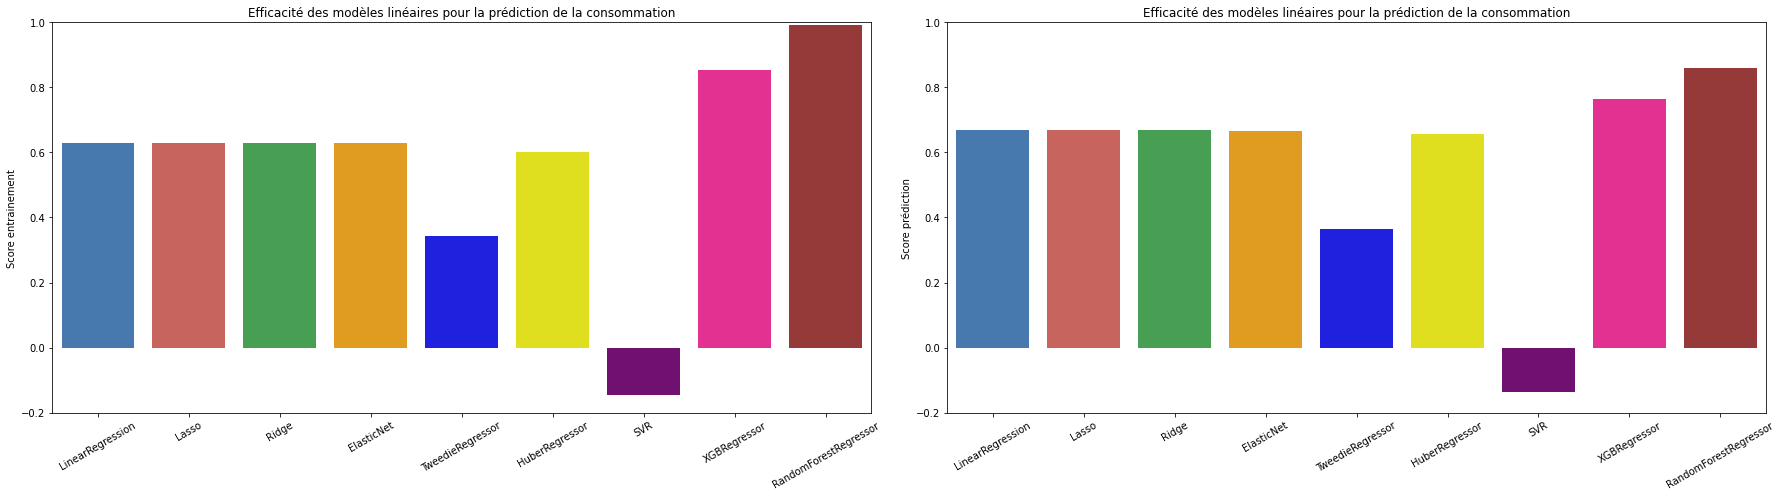

In [ ]:
df_graph_conso = df_results01_Consommation.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score entrainement"].values, data=df_graph_conso, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score de prédiction"].values, data=df_graph_conso, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(-0.2, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(-0.2, 1))

plt.tight_layout()
#fig.savefig("Performance modèles variables quantif consommation", dpi=400)

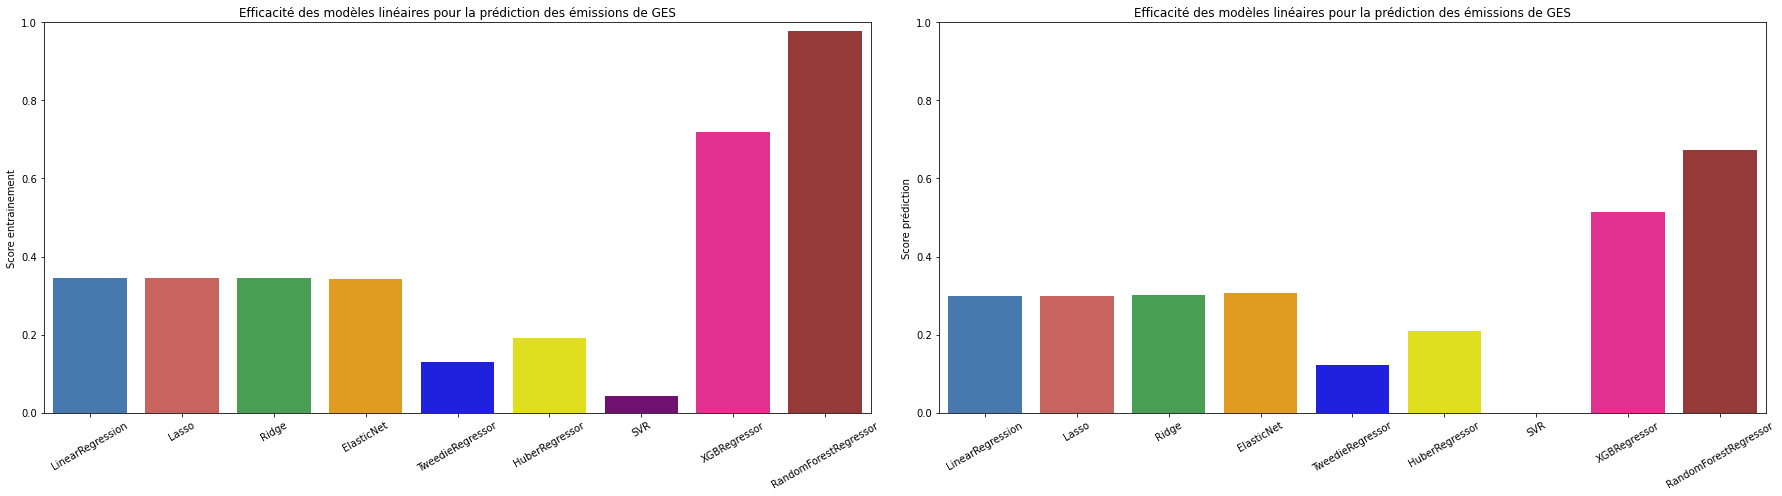

In [ ]:
df_graph_conso = df_results01_GESEmission.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score entrainement"].values, data=df_graph_conso, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score de prédiction"].values, data=df_graph_conso, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction des émissions de GES')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction des émissions de GES')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(0, 1))


plt.tight_layout()
fig.savefig("Performance modèles variables quantif GES émission", dpi=400)

Le modèle RandomForest semble être le plus efficace. Peut-on quand même optimiser ses prédictions en optimisant le choix des paramètres ?

## Optimisation du modèle de machine learning : Validation croisée et choix des hyperparamètres

On va chercher les meilleurs paramètres par un "*grid search*"

Prédiction de la consommation :

In [ ]:
# création des différentes valeurs possibles pour les différents paramètres
parameters = {"n_estimators" : [10,20,30],"max_features": ["auto", "sqrt", "log2"], "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)], "min_samples_split": [2,4,8], "min_samples_leaf": [1, 2, 4], "bootstrap": [True, False],}

In [ ]:
# Je mets ce code en commentaire car très long à executer

# Application de la grid search pour obtenir les meilleurs paramètres du modèles
X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25, random_state = 7)
# je centre-réduit les données pour un gain de temps
X_train=StandardScaler().fit_transform(X_train)
model = RandomForestRegressor()
rf_GridSearchCV_conso = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs=-1)
rf_GridSearchCV_conso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]})

Il est a noté ici que le temps de calcul du code ci-dessus requiert **9min**.

Ce long temps de calcul sera à mettre en relief du gain en performance du modèle (peut-être que le gain en performance optenu ici n'est pas significatif par rapport à la lourdeur d'application du code).

In [ ]:
# Je mets ce code en commentaire car le précédent est très long à executer, les paramètres en sortie sont ceux dans le bloc de code ci-dessous
rf_GridSearchCV_conso.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

Application des meilleurs hyperparamètres :

In [ ]:
df_results = run_model_and_performance_check("Consommation", RandomForestRegressor(bootstrap = False, max_depth = 20, max_features="sqrt", min_samples_leaf = 1, min_samples_split=4, n_estimators=30))
results_regression = df_results
df_results01_Consommation["RandomForestRegressor_Optimised"] = results_regression
df_results

Prédiction de la consommation : 



,"RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',\n min_samples_split=4, n_estimators=3"
Score entrainement,9.924124e-01
Score de prédiction,8.573943e-01
MAE,7.789493e+05
RMSE,1.562397e+06
median absolute error,2.853926e+05


Prédiction de l'émission des GES :

In [ ]:
# Je mets ce code en commentaire car très long à executer

# Application de la grid search pour obtenir les meilleurs paramètres du modèles
X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25, random_state = 7)
# Je centre-réduit les données pour un gain de temps
X_train=StandardScaler().fit_transform(X_train)
model = RandomForestRegressor()
rf_GridSearchCV_GES = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs=-1)
rf_GridSearchCV_GES.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]})

Il est a noté ici que le temps de calcul du code ci-dessus requiert **8min**.

Ce long temps de calcul sera à mettre en relief du gain en performance du modèle (peut-être que le gain en performance optenu ici n'est pas significatif par rapport à la lourdeur d'application du code).

In [ ]:
# Je mets ce code en commentaire car le précédent est très long à executer, les paramètres en sortie sont ceux dans le bloc de code ci-dessous
rf_GridSearchCV_GES.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

Application des hyperparamètres optimaux :

In [ ]:
df_results = run_model_and_performance_check("EmissionGES", RandomForestRegressor(bootstrap = False, max_depth = 60, max_features="sqrt", min_samples_leaf = 1, min_samples_split=4, n_estimators=10))
results_regression = df_results
df_results01_GESEmission["RandomForestRegressor_Optimised"] = results_regression
df_results

Prédiction des Emission de GES : 



,"RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',\n min_samples_split=4, n_estimators=1"
Score entrainement,0.980487
Score de prédiction,0.694269
MAE,25.139185
RMSE,51.133965
median absolute error,9.134500


Présentation des résultats d'optimisation des hyperparamètres sur le modèle RandomForestRegressor

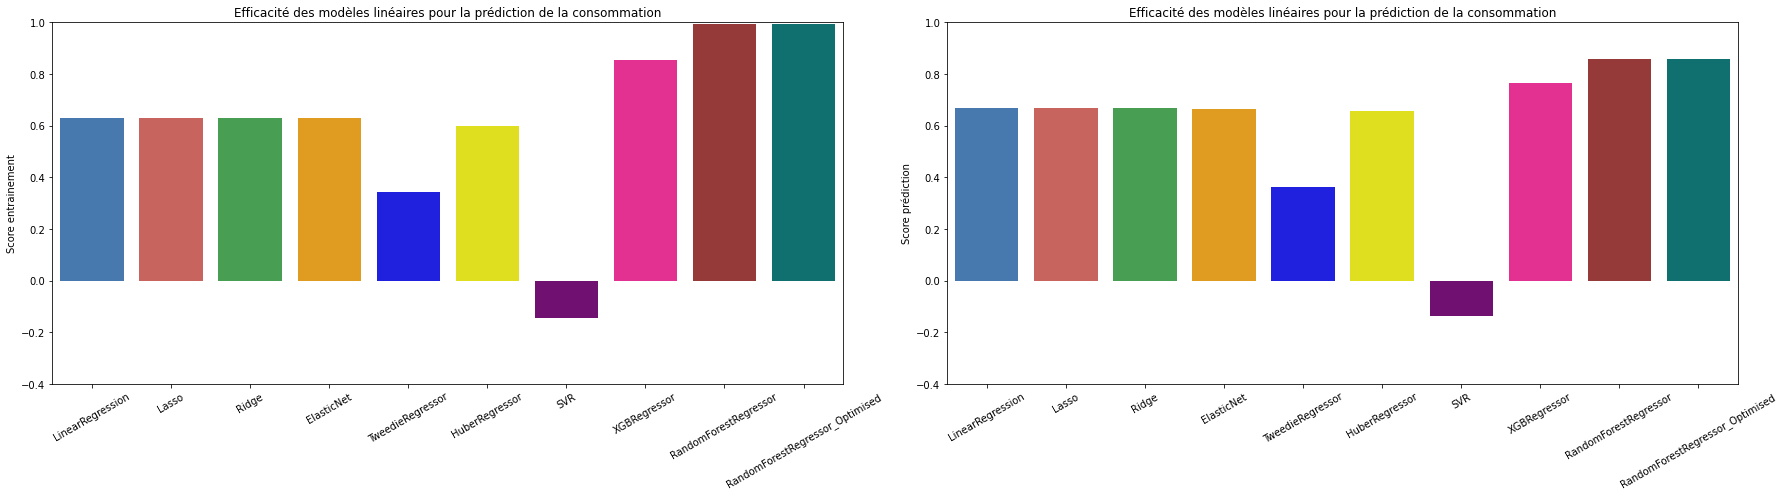

In [ ]:
df_graph_conso = df_results01_Consommation.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score entrainement"].values, data=df_graph_conso, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score de prédiction"].values, data=df_graph_conso, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(-0.4, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(-0.4, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif consommation optimisation RF", dpi=400)

In [ ]:
df_barplot_conso = df_graph_conso.drop('LinearRegression') 
df_barplot_conso = df_barplot_conso.drop('Lasso')
df_barplot_conso = df_barplot_conso.drop('Ridge') 
df_barplot_conso = df_barplot_conso.drop('ElasticNet') 
df_barplot_conso = df_barplot_conso.drop('TweedieRegressor') 
df_barplot_conso = df_barplot_conso.drop('HuberRegressor') 
df_barplot_conso = df_barplot_conso.drop('SVR') 
df_barplot_conso = df_barplot_conso.drop('XGBRegressor') 

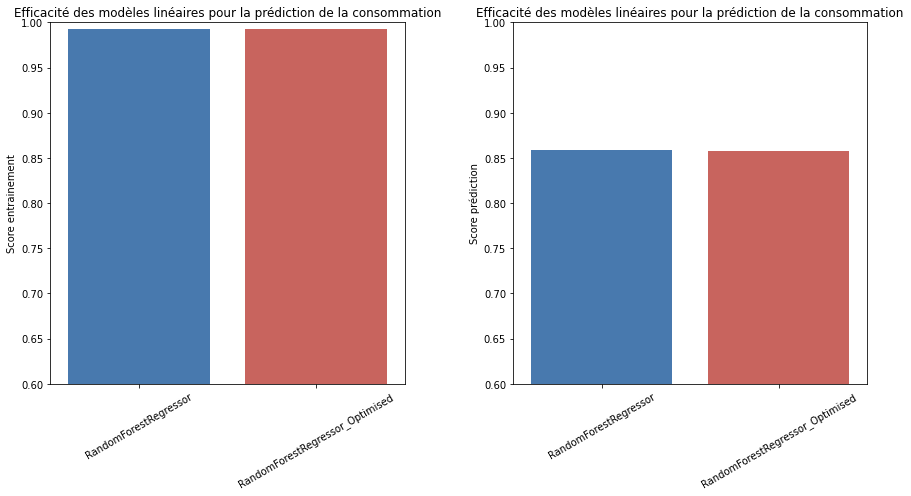

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
ax1 = sns.barplot(x=df_barplot_conso.index, y=df_barplot_conso["Score entrainement"].values, data=df_barplot_conso, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_barplot_conso.index, y=df_barplot_conso["Score de prédiction"].values, data=df_barplot_conso, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0.6, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(0.6, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif consommation optimisation RF2", dpi=400)

On remarque ici que l'optimisation du modèle de RandomForest créé de l'overfitting sur le jeu d'entrainement pour la prédiction de la consommation

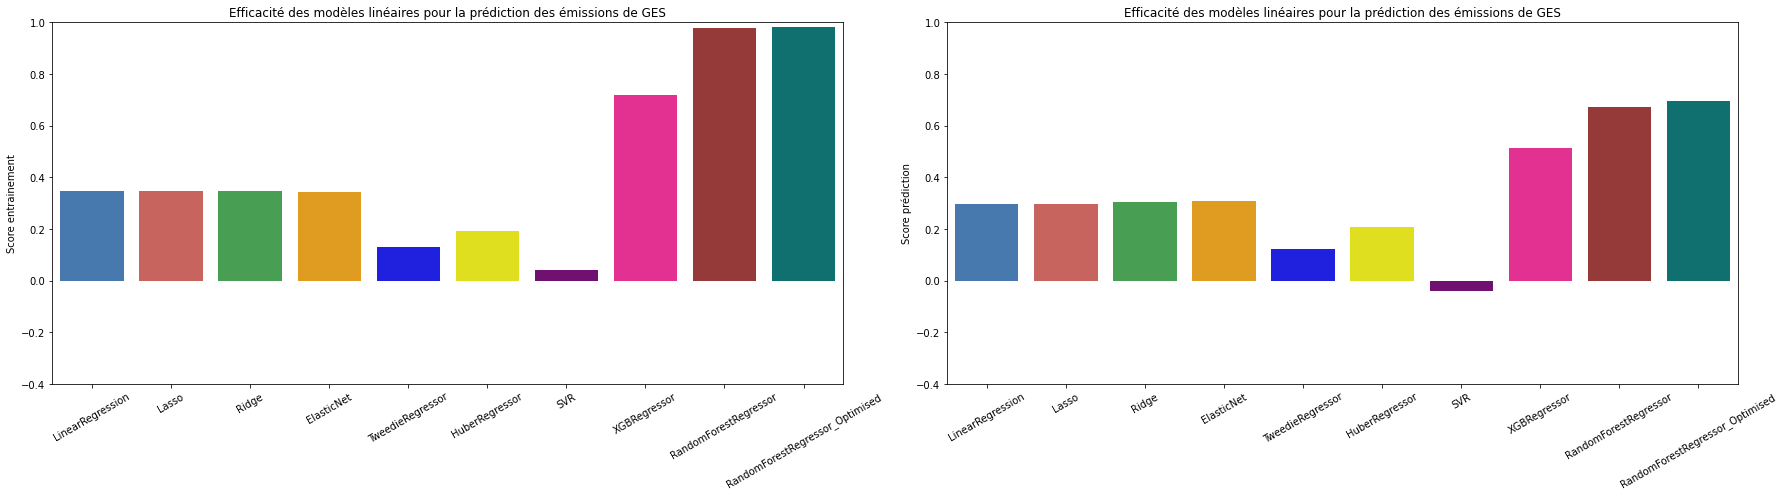

In [ ]:
df_graph_GES = df_results01_GESEmission.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_GES.index, y=df_graph_GES["Score entrainement"].values, data=df_graph_GES, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_GES.index, y=df_graph_GES["Score de prédiction"].values, data=df_graph_GES, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction des émissions de GES')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(-0.4, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction des émissions de GES')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(-0.4, 1))


plt.tight_layout()
fig.savefig("Performance modèles variables quantif GES émission optimisation RF", dpi=400)

In [ ]:
df_barplotGES = df_graph_GES.drop('LinearRegression') 
df_barplotGES = df_barplotGES.drop('Lasso')
df_barplotGES = df_barplotGES.drop('Ridge') 
df_barplotGES = df_barplotGES.drop('ElasticNet') 
df_barplotGES = df_barplotGES.drop('TweedieRegressor') 
df_barplotGES = df_barplotGES.drop('HuberRegressor') 
df_barplotGES = df_barplotGES.drop('SVR') 
df_barplotGES = df_barplotGES.drop('XGBRegressor') 

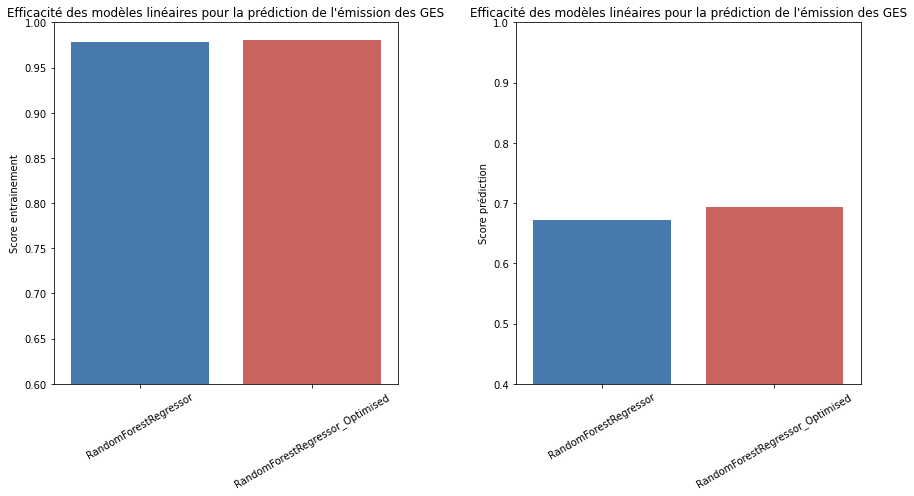

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
ax1 = sns.barplot(x=df_barplotGES.index, y=df_barplotGES["Score entrainement"].values, data=df_barplotGES, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_barplotGES.index, y=df_barplotGES["Score de prédiction"].values, data=df_barplotGES, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title("Efficacité des modèles linéaires pour la prédiction de l'émission des GES")
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0.6, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title("Efficacité des modèles linéaires pour la prédiction de l'émission des GES")
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(0.4, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif GES optimisation RF2", dpi=400)

L'optimisation par validation croisée et grid search améliore l'algorithme de RandomForest. On peut cependant noté que l'entrainement prend beaucoup de temps (environ 8min sur google collab) pour un gain en performance relativement faible pour la prédiction de la consommation (0.87 (optimisé) à la place de 0.81 (non-optimisé)) et provoque un overfitting pour la prédiction des émissions de GES.

## Importance de normalisation de type log sur les variables d'intérêt (consommation et émission de GES) :

In [ ]:
# Pour la prédiction de la consommation en énergie
X = X[features_Quant]
Y_conso = Y['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, Y_conso, test_size=0.25, random_state = 7)
model_regr_RF_Consommation_nolog = RandomForestRegressor(bootstrap = False, max_depth=None, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_regr_RF_Consommation_nolog.fit(X_train, y_train)
y_pred = model_regr_RF_Consommation_nolog.predict(X_test)
print("Efficacité du modèle de régression Random Forest sans normalisation log :")
print("Score entrainement = ",model_regr_RF_Consommation_nolog.score(X_train,y_train))
print("Score de prédiction = ",model_regr_RF_Consommation_nolog.score(X_test,y_test))

y_trainlog_conso = np.log(1+y_train)
y_testlog_conso = np.log(1+y_test)
model_regr_RF_Consommation_log = RandomForestRegressor(bootstrap = False, max_depth=None, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_regr_RF_Consommation_log.fit(X_train, y_trainlog_conso)
y_pred = model_regr_RF_Consommation_log.predict(X_test)
results_conso_log = np.array([model_regr_RF_Consommation_log.score(X_train,y_trainlog_conso), model_regr_RF_Consommation_log.score(X_test,y_testlog_conso), mean_absolute_error(y_testlog_conso,y_pred), np.sqrt(mean_squared_error(y_testlog_conso,y_pred)), median_absolute_error(y_testlog_conso,y_pred)])
df_barplot_conso.loc[2]=[results_conso_log[0],results_conso_log[1],results_conso_log[2], results_conso_log[3], results_conso_log[4]]
print("\nEfficacité du modèle de régression Random Forest avec normalisation log : ")
print("Score entrainement = ",model_regr_RF_Consommation_log.score(X_train,y_trainlog_conso))
print("Score de prédiction = ",model_regr_RF_Consommation_log.score(X_test,y_testlog_conso))

Efficacité du modèle de régression Random Forest sans normalisation log :
Score entrainement =  0.996884487729903
Score de prédiction =  0.8699023150231211

Efficacité du modèle de régression Random Forest avec normalisation log : 
Score entrainement =  0.9952258349886923
Score de prédiction =  0.8651494493702925


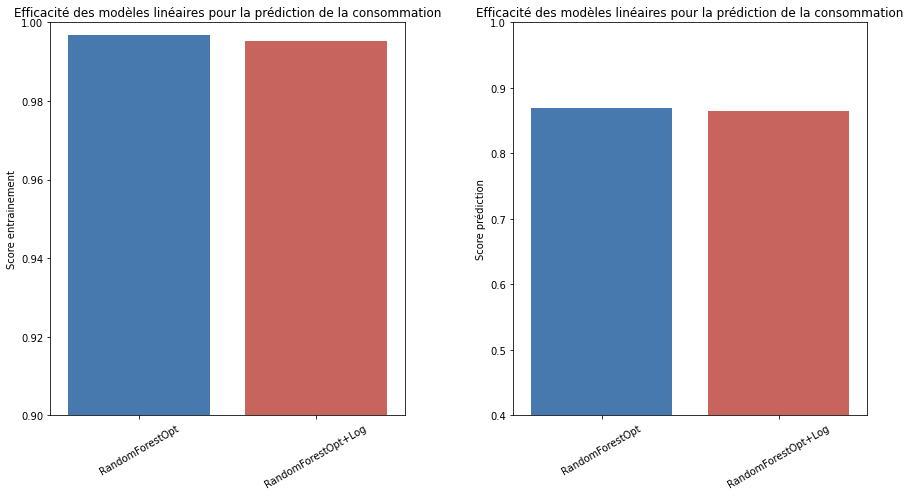

In [ ]:
y1 = [model_regr_RF_Consommation_nolog.score(X_train,y_train), model_regr_RF_Consommation_log.score(X_train,y_trainlog_conso)]
x1 = ["RandomForestOpt", "RandomForestOpt+Log"]
y2 = [model_regr_RF_Consommation_nolog.score(X_test,y_test), model_regr_RF_Consommation_log.score(X_test,y_testlog_conso)]
x2 = x1
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
ax1 = sns.barplot(x=x1, y=y1, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=x2, y=y2, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title("Efficacité des modèles linéaires pour la prédiction de la consommation")
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0.9, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title("Efficacité des modèles linéaires pour la prédiction de la consommation")
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(0.4, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif consommation optimisation + Log RF", dpi=400)

Il n'y a pas d'intérêt à normaliser les données de consommation par le log

In [ ]:
# Pour la prédiction de l'émission de GES
X = X[features_Quant]
Y_conso = Y['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, Y_conso, test_size=0.25)
model_regr_RF_GESEmission_nolog = RandomForestRegressor(bootstrap = False, max_depth=None, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_regr_RF_GESEmission_nolog.fit(X_train, y_train)
y_pred = model_regr_RF_Consommation_nolog.predict(X_test)
print("Efficacité du modèle de régression Random Forest sans normalisation log :")
print("Score entrainement = ",model_regr_RF_GESEmission_nolog.score(X_train,y_train))
print("Score de prédiction = ",model_regr_RF_GESEmission_nolog.score(X_test,y_test))

y_trainlog_conso = np.log(1+y_train)
y_testlog_conso = np.log(1+y_test)
model_regr_RF_GESEmission_log = RandomForestRegressor(bootstrap = False, max_depth=None, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_regr_RF_GESEmission_log.fit(X_train, y_trainlog_conso)
y_pred = model_regr_RF_GESEmission_log.predict(X_test)
results_conso_log = np.array([model_regr_RF_GESEmission_log.score(X_train,y_trainlog_conso), model_regr_RF_GESEmission_log.score(X_test,y_testlog_conso), mean_absolute_error(y_testlog_conso,y_pred), np.sqrt(mean_squared_error(y_testlog_conso,y_pred)), median_absolute_error(y_testlog_conso,y_pred)])
df_barplot_conso.loc[2]=[results_conso_log[0],results_conso_log[1],results_conso_log[2], results_conso_log[3], results_conso_log[4]]
print("\nEfficacité du modèle de régression Random Forest avec normalisation log : ")
print("Score entrainement = ",model_regr_RF_GESEmission_log.score(X_train,y_trainlog_conso))
print("Score de prédiction = ",model_regr_RF_GESEmission_log.score(X_test,y_testlog_conso))

Efficacité du modèle de régression Random Forest sans normalisation log :
Score entrainement =  0.9934060581569996
Score de prédiction =  0.7097313651909005

Efficacité du modèle de régression Random Forest avec normalisation log : 
Score entrainement =  0.9959829137775107
Score de prédiction =  0.7022409786490782


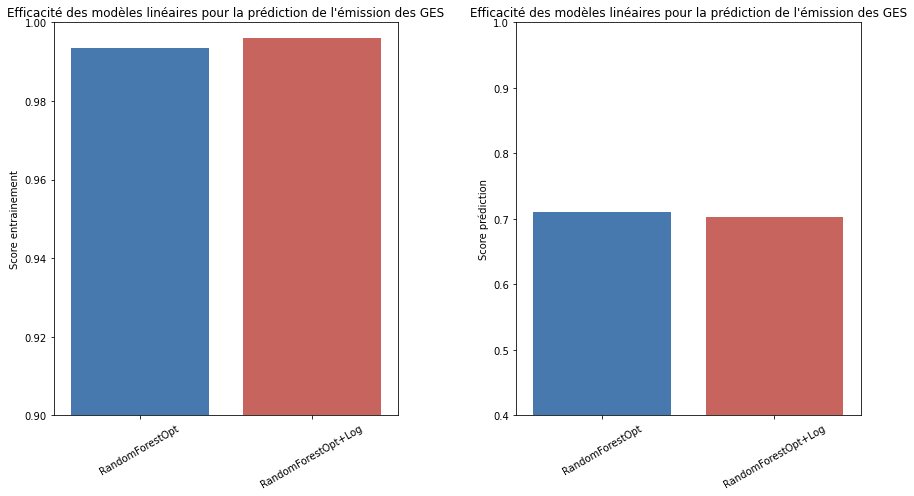

In [ ]:
y1 = [model_regr_RF_GESEmission_nolog.score(X_train,y_train), model_regr_RF_GESEmission_log.score(X_train,y_trainlog_conso)]
x1 = ["RandomForestOpt", "RandomForestOpt+Log"]
y2 = [model_regr_RF_GESEmission_nolog.score(X_test,y_test), model_regr_RF_GESEmission_log.score(X_test,y_testlog_conso)]
x2 = x1
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
ax1 = sns.barplot(x=x1, y=y1, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=x2, y=y2, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title("Efficacité des modèles linéaires pour la prédiction de l'émission des GES")
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0.9, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title("Efficacité des modèles linéaires pour la prédiction de l'émission des GES")
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(0.4, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif GES optimisation + Log RF", dpi=400)

Il y aurait un léger intérêt à normaliser les données d'émission de GES par le log

# Utilisation des variables quantitatives ET qualitatives

Les modèles de prédiction peuvent prendre en entrée des variables catégorielles si au préalable, une transformation incluant des encoders est effectuée.

L'objectif ici est de tester la plus-value à utiliser ce mode d'entrainement de modèle de machine learning.

## Modélisation linéaire, test des différents algorithmes

In [ ]:
Y = data[to_predict_features]
X = data.drop(to_predict_features, axis=1)

In [ ]:
X.columns

Index(['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'YearBuilt_age', 'GFA_per_floor',
       'Building_age'],
      dtype='object')

In [ ]:
features_Quant = ['CouncilDistrictCode', 'NumberofFloors','PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'GFA_per_floor','Building_age']
features_Qual = ['PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'YearBuilt_age']

Standardisation des données

In [ ]:
preprocessor = make_column_transformer((RobustScaler(),features_Quant),(OneHotEncoder(handle_unknown = 'ignore'),features_Qual))

  ### Régression linéaire basic


Prédiction de la consommation :

In [ ]:
def run_model_and_performance_check_with_Quali(feature_to_predict, model):
   # Sélection des données
  if feature_to_predict == "Consommation":
    X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25, random_state=7)
  if feature_to_predict == "EmissionGES":
    X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25, random_state=7)

  # Choix du model et entrainement
  model_regr = make_pipeline(preprocessor,model)
  model_regr.fit(X_train, y_train)

  # Prédiction du modèle et archivage des résultats
  y_pred = model_regr.predict(X_test)
 
  # Création des dataframes résultats
  results_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = [str(model)[:-2]])
  df_results[str(model)[:-2]] = results_regression

  # Ennoncé des résultats de performance du modèle
  if feature_to_predict == "Consommation":
    print("Prédiction de la consommation : \n")
  if feature_to_predict == "EmissionGES":
    print("Prédiction des Emission de GES : \n")

  return df_results

In [ ]:
run_model_and_performance_check_with_Quali("Consommation", LinearRegression())

Prédiction de la consommation : 



,LinearRegression
Score entrainement,7.156261e-01
Score de prédiction,7.134886e-01
MAE,1.423770e+06
RMSE,2.214592e+06
median absolute error,9.654726e+05


Prédiction de l'émission de GES :

In [ ]:
run_model_and_performance_check_with_Quali("EmissionGES", LinearRegression())

Prédiction des Emission de GES : 



,LinearRegression
Score entrainement,0.516256
Score de prédiction,0.434288
MAE,43.267042
RMSE,69.556452
median absolute error,27.457283


Prédiction de la consommation ET de l'émission de GES:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 7)

model_regr = make_pipeline(preprocessor,LinearRegression())
model_regr.fit(X_train, y_train)
y_pred = model_regr.predict(X_test)

print("Efficacité du modèle de régression linéaire basic : \n")
print("Score entrainement = ",model_regr.score(X_train,y_train))
print("\nErreur de prédiction : ")
print(" MAE = ",mean_absolute_error(y_test,y_pred))
print(" RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print(" median abs err = ",median_absolute_error(y_test,y_pred))

Efficacité du modèle de régression linéaire basic : 

Score entrainement =  0.6159407963317719

Erreur de prédiction : 
 MAE =  711906.7721064793
 RMSE =  1565953.2612351342
 median abs err =  482750.0166488208


  ### Régression Random Forest

In [ ]:
run_model_and_performance_check_with_Quali("Consommation", RandomForestRegressor())

Prédiction de la consommation : 



,RandomForestRegressor
Score entrainement,9.705936e-01
Score de prédiction,8.674222e-01
MAE,8.137752e+05
RMSE,1.506462e+06
median absolute error,3.869253e+05


In [ ]:
run_model_and_performance_check_with_Quali("EmissionGES", RandomForestRegressor())

Prédiction des Emission de GES : 



,RandomForestRegressor
Score entrainement,0.935863
Score de prédiction,0.734064
MAE,25.037041
RMSE,47.690075
median absolute error,11.772517


  ### Test d'autres modèles de régression linéaire et archivage des résultats dans une dataframe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25)
df_results_Consommation = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearRegression"])
for i in range(len(List_of_models)):
  model_regr = make_pipeline(preprocessor,List_of_models[i])
  model_regr.fit(X_train, y_train)
  y_pred = model_regr.predict(X_test)
  results_linear_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results_Consommation[List_of_models_for_graph[i]] = results_linear_regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2427281074497719.5, tolerance: 1819331459054.6633
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3489804710782894.0, tolerance: 1819331459054.6633
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: 

[07:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_results_Consommation

,LinearRegression,Lasso,Ridge,ElasticNet,TweedieRegressor,HuberRegressor,SVR,XGBRegressor,RandomForestRegressor
Score entrainement,7.330777e-01,7.330897e-01,1.406238e-01,6.717015e-01,4.210859e-01,1.831979e-01,-1.413777e-01,8.914171e-01,9.893873e-01
Score de prédiction,6.701082e-01,6.702725e-01,1.375812e-01,6.363152e-01,3.626013e-01,1.665540e-01,-1.624729e-01,7.794377e-01,8.435578e-01
MAE,1.557228e+06,1.555546e+06,2.570783e+06,1.536821e+06,2.522153e+06,2.195154e+06,2.650198e+06,1.135837e+06,8.099781e+05
RMSE,2.475801e+06,2.475184e+06,4.003031e+06,2.599516e+06,3.441402e+06,3.935217e+06,4.647520e+06,2.024396e+06,1.704931e+06
median absolute error,1.032197e+06,1.032617e+06,1.902492e+06,7.748467e+05,1.970968e+06,1.141536e+06,1.242016e+06,6.418165e+05,3.853562e+05


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25)
df_results_GESEmission = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearRegression"])
for i in range(len(List_of_models)):
  model_regr = make_pipeline(preprocessor,List_of_models[i])
  model_regr.fit(X_train, y_train)
  y_pred = model_regr.predict(X_test)
  results_linear_regression = np.array([model_regr.score(X_train,y_train), model_regr.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results_GESEmission[List_of_models_for_graph[i]] = results_linear_regression
  df_results_GESEmission

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3229719.8160921214, tolerance: 957.6037987719235
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lb

[07:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_results_GESEmission

,LinearRegression,Lasso,Ridge,ElasticNet,TweedieRegressor,HuberRegressor,SVR,XGBRegressor,RandomForestRegressor
Score entrainement,0.536794,0.520838,0.021895,0.402198,0.415948,0.118365,0.123315,0.795312,0.973917
Score de prédiction,0.370686,0.373631,0.054051,0.346300,0.365625,0.105783,0.030978,0.582271,0.707049
MAE,46.971861,46.008098,62.322445,46.649517,44.594048,49.133314,46.457163,37.497754,27.685559
RMSE,78.999718,78.814691,96.855830,80.515829,79.316723,94.170187,98.029955,64.363435,53.900119
median absolute error,26.841047,25.784858,50.365782,29.560045,24.534779,26.629273,20.648580,20.509662,12.753788


In [ ]:
custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

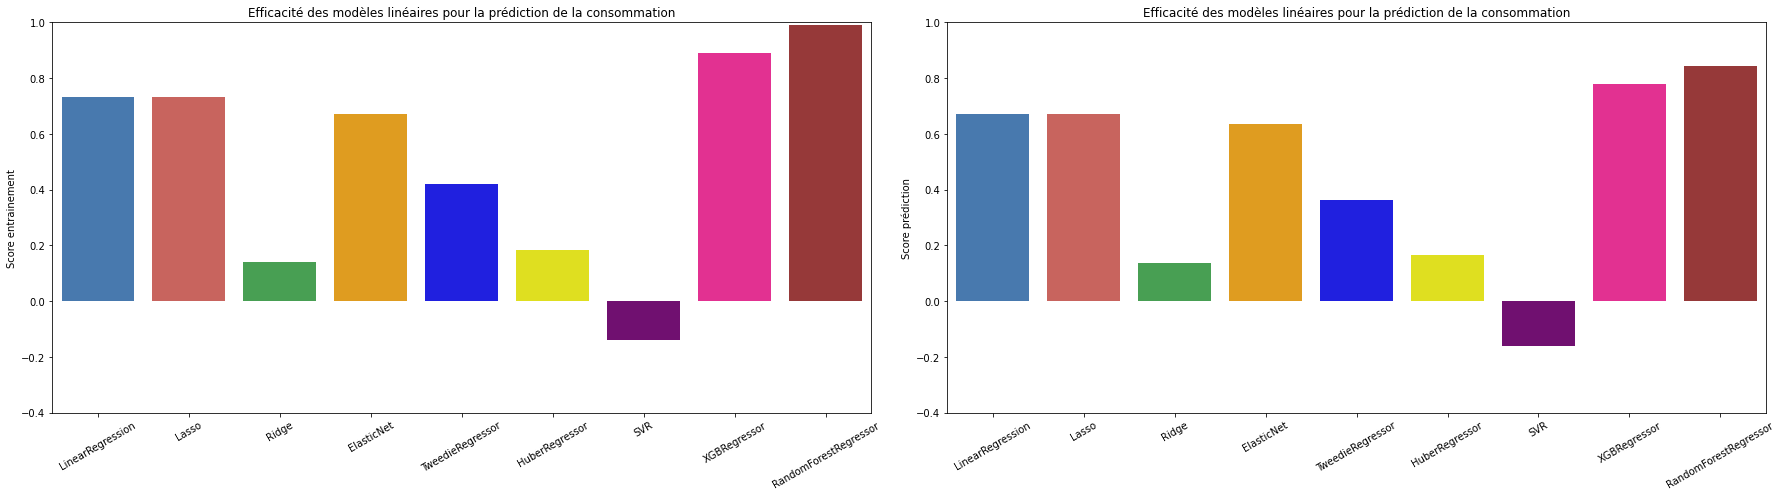

In [ ]:
df_graph_conso = df_results_Consommation.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score entrainement"].values, data=df_graph_conso, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_conso.index, y=df_graph_conso["Score de prédiction"].values, data=df_graph_conso, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(-0.4, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction de la consommation')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(-0.4, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif-quali consommation", dpi=400)

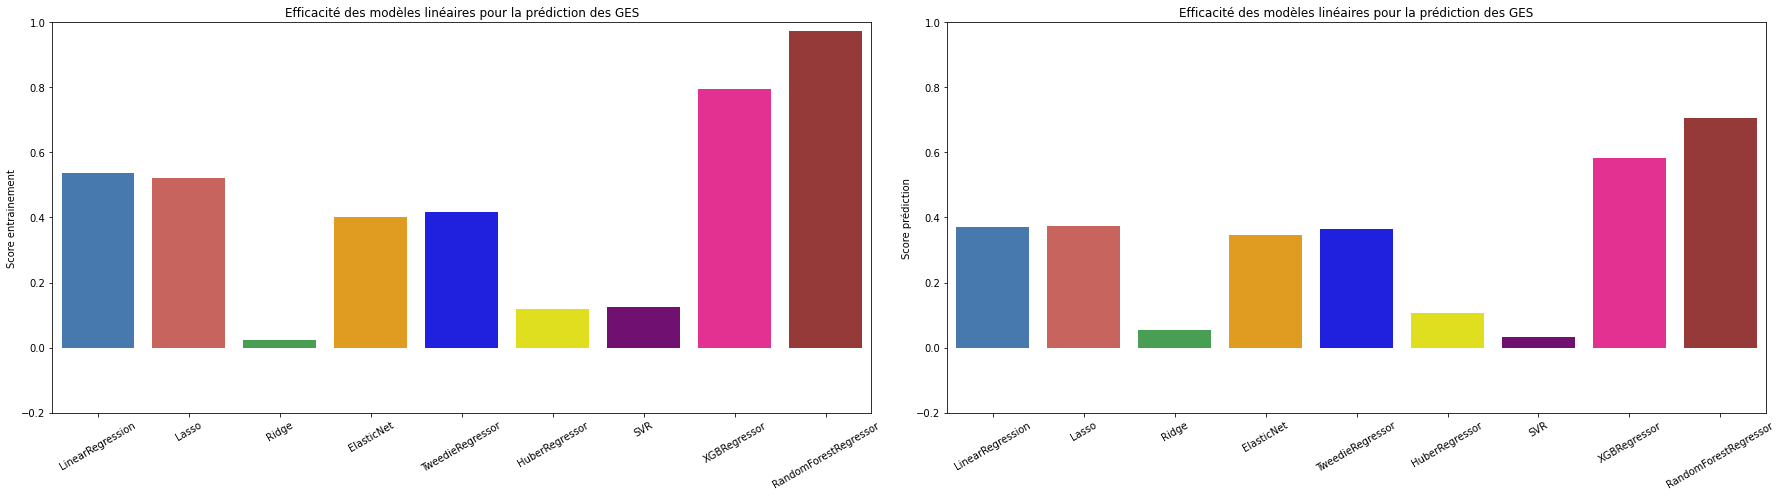

In [ ]:
df_graph_GES = df_results_GESEmission.transpose()
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
ax1 = sns.barplot(x=df_graph_GES.index, y=df_graph_GES["Score entrainement"].values, data=df_graph_GES, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph_GES.index, y=df_graph_GES["Score de prédiction"].values, data=df_graph_GES, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_title('Efficacité des modèles linéaires pour la prédiction des GES')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(-0.2, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_title('Efficacité des modèles linéaires pour la prédiction des GES')
ax2.set_ylabel('Score prédiction')
ax2.set(ylim=(-0.2, 1))

plt.tight_layout()
fig.savefig("Performance modèles variables quantif-quali GES émission", dpi=400)

# CONCLUSION :      
Les performances sont globalement similaires en comparaison aux performances des modèles n'incluant pas les variables catégorielles.

Dans les deux cas l'algorithme *RandomForestRegressor* est le plus performant suivi par l'algorithme *XGBRegressor*

Visualisation finale de la validation de notre approche

In [ ]:
X = X[features_Quant]
X_train, X_test, y_train, y_test = train_test_split(X, Y['SiteEnergyUse(kBtu)'], test_size=0.25)
model_regr_RF_Consommation = RandomForestRegressor(bootstrap = False, max_depth = 20, max_features="sqrt", min_samples_leaf = 1, min_samples_split=4, n_estimators=30)
model_regr_RF_Consommation.fit(X_train, y_train)
data["Predicted_consommation"] = model_regr_RF_Consommation.predict(data[features_Quant])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


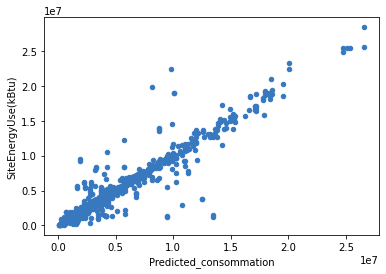

In [ ]:
data.plot.scatter(x="Predicted_consommation",y="SiteEnergyUse(kBtu)")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['TotalGHGEmissions'], test_size=0.25, random_state = 7)
model_regr = RandomForestRegressor(bootstrap = False, max_depth=None, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_regr.fit(X_train, y_train)
data["Predicted_GES-emission"] = model_regr.predict(data[features_Quant])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


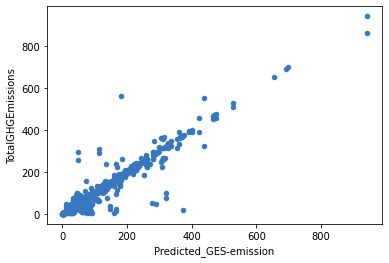

In [ ]:
data.plot.scatter(x="Predicted_GES-emission",y="TotalGHGEmissions")

In [ ]:
data.head()

,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),TotalGHGEmissions,YearBuilt_age,GFA_per_floor,Building_age,Predicted_consommation,Predicted_GES-emission
0,Hotel,7.0,DOWNTOWN,12.0,88434.0,0.0,88434.0,Hotel,88434.0,6981428.0,249.43,old,7369.500000,95.0,7.075277e+06,249.705
1,Hotel,7.0,DOWNTOWN,11.0,103566.0,15064.0,88502.0,Hotel,83880.0,8354235.0,263.51,old,9415.090909,26.0,5.718227e+06,279.685
2,Hotel,7.0,DOWNTOWN,11.0,83008.0,0.0,83008.0,Hotel,81352.0,6252842.0,208.46,old,7546.181818,96.0,6.022525e+06,192.300
3,Hotel,7.0,DOWNTOWN,15.0,163984.0,0.0,163984.0,Hotel,163984.0,12633744.0,331.61,old,10932.266667,118.0,1.199774e+07,361.885
4,Hotel,7.0,DOWNTOWN,9.0,65009.0,0.0,65009.0,Hotel,65009.0,6807227.0,334.87,old,7223.222222,94.0,6.374925e+06,328.230


## Importance des features pour la modélisation :     
 
 Il y a t-il des features qui sont primordiaux pour la modélisation et qu'il faudra donc garder dans les années à suivre et au contraire existe-t-il des features dont nous pourrions nous passer (et ainsi gagner du temps sur le terrain dans la préparation de la base de donnée) ?


Pour la prédiction de la consommation :

In [ ]:
# Calcul des coefficients relevant l'importance de chaque features
coefficients = abs(rf_GridSearchCV_conso.best_estimator_.feature_importances_)
liste_coef_conso = pad.concat((pad.DataFrame(X.columns, columns = ['Variables']), pad.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

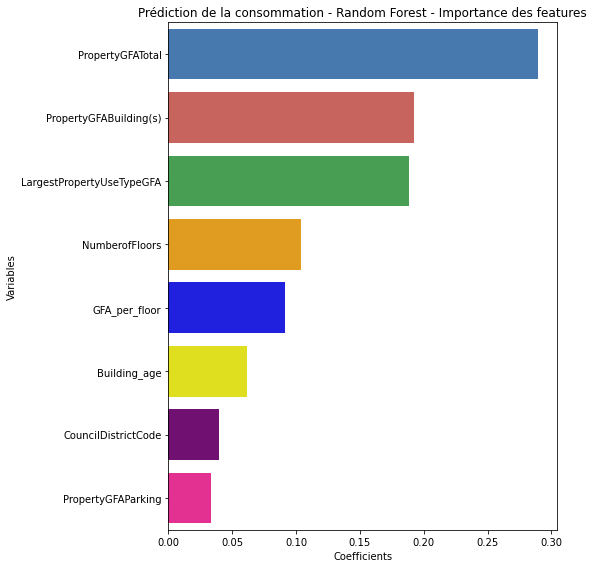

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Prédiction de la consommation - Random Forest - Importance des features')
ax = sns.barplot(y = liste_coef_conso['Variables'], x = liste_coef_conso['Coefficients'])
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Importance des features consommation", dpi=400)
plt.show()

De façon assez logique, les surfaces des batiments et étages sont importants pour la création du modèle, vient ensuite le nombre d'étage, l'âge du batiment et enfin le n° du district où se situe le batiment

Pour la prédiction des émissions de GES :

In [ ]:
# Calcul des coefficients relevant l'importance de chaque features
coefficients = abs(rf_GridSearchCV_GES.best_estimator_.feature_importances_)
liste_coef = pad.concat((pad.DataFrame(X.columns, columns = ['Variables']), pad.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

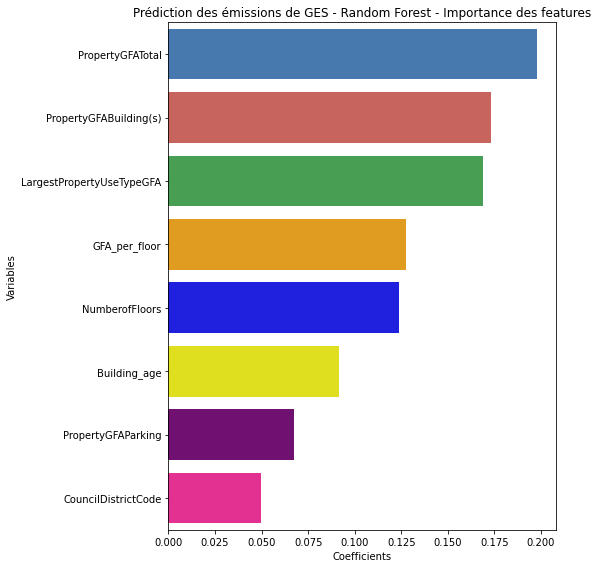

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Prédiction des émissions de GES - Random Forest - Importance des features')
ax = sns.barplot(y = liste_coef['Variables'], x = liste_coef['Coefficients'])
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Importance des features émission GES", dpi=400)
plt.show()

De façon assez logique, les surfaces des batiments et étages sont importants pour la création du modèle, vient ensuite le nombre d'étage, l'âge du batiment et enfin le n° du district où se situe le batiment